In [7]:
# imports
import pandas as pd
import datasets
import os
from dotenv import load_dotenv
from sklearn.model_selection import GroupShuffleSplit
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    PreTrainedTokenizerFast
)
from datasets import load_from_disk
import json
import typer
import torch
from pathlib import Path

from utils import (plot_v_gene_distributions, 
                   set_seed, 
                   MetricCallback, 
                    )

import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../predict'))
sys.path.append(parent_dir)

from predict import main as predict


/home/ubuntu/miniconda3/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Load in environment variables
load_dotenv()

dataset_path = os.getenv('DATASET_PATH')
independent_dataset_1 = os.getenv('INDEPENDENT_DATASET_PATH_1')
independent_dataset_2 = os.getenv('INDEPENDENT_DATASET_PATH_2')
tokenizer_path = os.getenv('TOKENIZER_PATH')
untrained_model_path = os.getenv('UNTRAINED_MODEL_PATH')


In [9]:
# import original dataset to use for training
antibody_dataset = pd.read_parquet(dataset_path)


In [ ]:
# clean the dataset before training

# create the full amino acid sequence of the antibodies by concatenating the various parts
antibody_dataset['sequence_aa'] = antibody_dataset['fwr1_aa'] + antibody_dataset['cdr1_aa'] + antibody_dataset['fwr2_aa'] + antibody_dataset['cdr2_aa'] + antibody_dataset['fwr3_aa'] + antibody_dataset['cdr3_aa'] + antibody_dataset['fwr4_aa']

# filter out data we do not want
cleaned_dataset = antibody_dataset[
    # Filter out light chains
    (antibody_dataset['chain_type'] == 'H') 
    # Filter out vhh antibodies, which are smaller and a different structure
    & (antibody_dataset['vhh'] == False)  
    # Make sure there is a classification for the antibody, and only one classification, and it is not a weird useless one
    & (antibody_dataset['classification'] != '')
    & (~antibody_dataset['classification'].str.contains(';'))
    & (~antibody_dataset['classification'].isin(['other', 'methods development'])) 
    # Get rid of sequences with X as an amino acid
    & (~antibody_dataset['sequence_aa'].str.contains('X'))
    # Make sure all regions of sequence are present and sensible length
    & (antibody_dataset["fwr1_aa"].str.len() >= 10)
    & (antibody_dataset["fwr2_aa"].str.len() >= 1)
    & (antibody_dataset["fwr3_aa"].str.len() >= 1)
    & (antibody_dataset["fwr4_aa"].str.len() >= 10)
    & (antibody_dataset["cdr1_aa"].str.len() >= 5)
    & (antibody_dataset["cdr1_aa"].str.len() <= 12)
    & (antibody_dataset["cdr2_aa"].str.len() >= 3)
    & (antibody_dataset["cdr2_aa"].str.len() <= 10)
    & (antibody_dataset["cdr3_aa"].str.len() >= 5)
    & (antibody_dataset["cdr3_aa"].str.len() <= 30)
    # Remove sequences from the PDB, as fabcon was already trained on these
    & (antibody_dataset['is_source_pdb']!=True)
    # Then remove duplicates of the CDR1, 2, and 3 - leaving these in risks data leakage during training
].drop_duplicates(subset=['cdr1_aa', 'cdr2_aa', 'cdr3_aa'])
print("len filtered doaslap", len(cleaned_dataset))

# create a v_gene column which contains the v gene instead of the allele
# by removing everything after a * (which would signify the allele)
cleaned_dataset['v_gene'] = cleaned_dataset['v_call'].str.split("*", n=1).str[0]

# get human antibody sequences
human_dataset = cleaned_dataset[   
    (
        (cleaned_dataset['annotations_organism'] == 'Homo sapiens')
    & (cleaned_dataset['classification'].isin(['self-protein', 'peptide'])) | 
    (((cleaned_dataset['v_call_species'] == 'human') & (cleaned_dataset['classification'].isin(['self-protein'])))))
]

# get other antibody sequences
non_human_dataset = cleaned_dataset[(cleaned_dataset['classification'].isin(['viral', 
                                                                         'fungal', 
                                                                         'bacterial', 
                                                                         'parasitic', 
                                                                         'chemical compound']))]

# remove PDB data since it was already used in fabcon
human_dataset=human_dataset[human_dataset['is_source_pdb']==False]
non_human_dataset=non_human_dataset[non_human_dataset['is_source_pdb']==False]

# add labels for the machine learning binary classification
human_dataset['label'] = 1
non_human_dataset['label'] = 0


print('length of dataset after cleaning:', (pd.concat([human_dataset, non_human_dataset])).shape[0], 'sequences')


len filtered doaslap 77990
length of dataset after cleaning: 62296 sequences


In [11]:
# make a dataset which is 50/50 human/non-human
# Identify duplicated _seq values across both datasets
common_seqs = pd.concat([human_dataset['_seq'], non_human_dataset['_seq']]).duplicated(keep=False)

# Filter out rows with duplicated _seq values in each dataset
human_dataset = human_dataset[~human_dataset['_seq'].isin(common_seqs)]
non_human_dataset = non_human_dataset[~non_human_dataset['_seq'].isin(common_seqs)]

# Now, proceed with concatenating

min_length_data = min(len(human_dataset), len(non_human_dataset))

df = pd.concat([human_dataset.iloc[:min_length_data],non_human_dataset.iloc[:min_length_data]])

print('balanced dataset size:', len(df))



balanced dataset size: 46338


In [20]:
# split and tokenize the data
def stratified_group_split(df, stratify_col, group_col, random_state=4):
    # Create a combined stratification column that uses both v_gene and cdr3_aa
    df['strat_group'] = df[stratify_col].astype(str) + "_" + df[group_col].astype(str)
    
    # Use GroupShuffleSplit to ensure groups remain intact
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    train_idx, test_val_idx = next(splitter.split(df, groups=df["strat_group"]))

    df_test_val = df.iloc[test_val_idx]
    
    # Split the test_val set into test and validation
    splitter_val = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=random_state)
    val_idx, test_idx = next(splitter_val.split(df_test_val, groups=df_test_val["strat_group"]))
    
    # Create the final dataframes
    df_train = df.iloc[train_idx].copy()
    df_val = df_test_val.iloc[val_idx].copy()
    df_test = df_test_val.iloc[test_idx].copy()
    
    return df_train, df_val, df_test


df_train, df_val, df_test = stratified_group_split(
    df,
    stratify_col='cdr3_aa',
    group_col='v_gene',
    random_state=4
)

df_train['sequence_aa'] = 'Ḣ'+df_train['sequence_aa']
df_val['sequence_aa'] = 'Ḣ'+df_val['sequence_aa']
df_test['sequence_aa'] = 'Ḣ'+df_test['sequence_aa']

df_train.to_parquet('train.parquet')
df_val.to_parquet('val.parquet')
df_test.to_parquet('test.parquet')


dd = datasets.DatasetDict({
    "train": datasets.Dataset.from_pandas(df_train),
    "eval": datasets.Dataset.from_pandas(df_val),
    "test": datasets.Dataset.from_pandas(df_test)
})

tokenizer = PreTrainedTokenizerFast.from_pretrained(
   tokenizer_path,
    padding=True,
    max_len=256
)

dd_tokenized = dd.map(
    lambda z:tokenizer(
        z['sequence_aa'],
        padding=True
    ),
    batched=True,
    batch_size=32,
    remove_columns=['sequence_aa',
                    '_seq',
                    'id',
                    "strat_group",
                    'name',
                    'description',
                    'dbxrefs',
                    'annotations_date',
                    'annotations_db_source',
                    'annotations_source',
                    'annotations_organism',
                    'annotations_comment',
                    'protein_id',
                    'titles',
                    'pubmed_ids',
                    'journal',
                    'remarks',
                    'patent_sequence',
                    'patent_id',
                    'is_source_pdb',
                    'fwr1_aa',
                    'cdr1_aa',
                    'fwr2_aa',
                    'cdr2_aa',
                    'fwr3_aa',
                    'cdr3_aa',
                    'fwr4_aa',
                    'junction_aa',
                    'v_call',
                    'j_call',
                    'v_call_score',
                    'v_call_species',
                    'j_call_score',
                    'j_call_species',
                    'species',
                    'chain_type',
                    'tail',
                    'species_latin',
                    'v_region_mismatch',
                    'targets_from_titles',
                    'genes_from_titles',
                    'classification_from_titles',
                    'targets_from_abstracts',
                    'genes_from_abstracts',
                    'classification_from_abstracts',
                    'targets_from_pub_abstracts',
                    'genes_from_pub_abstracts',
                    'classification_from_pub_abstracts',
                    'vhh',
                    'gene_list',
                    'uniprot_id',
                    'gene',
                    'target',
                    'classification',
                    'v_gene',
                    '__index_level_0__'
                ]
).remove_columns('token_type_ids')



In [21]:
# save the tokenized data to disk
dd_tokenized.save_to_disk("datasetdict_tokenized_labelled.set")


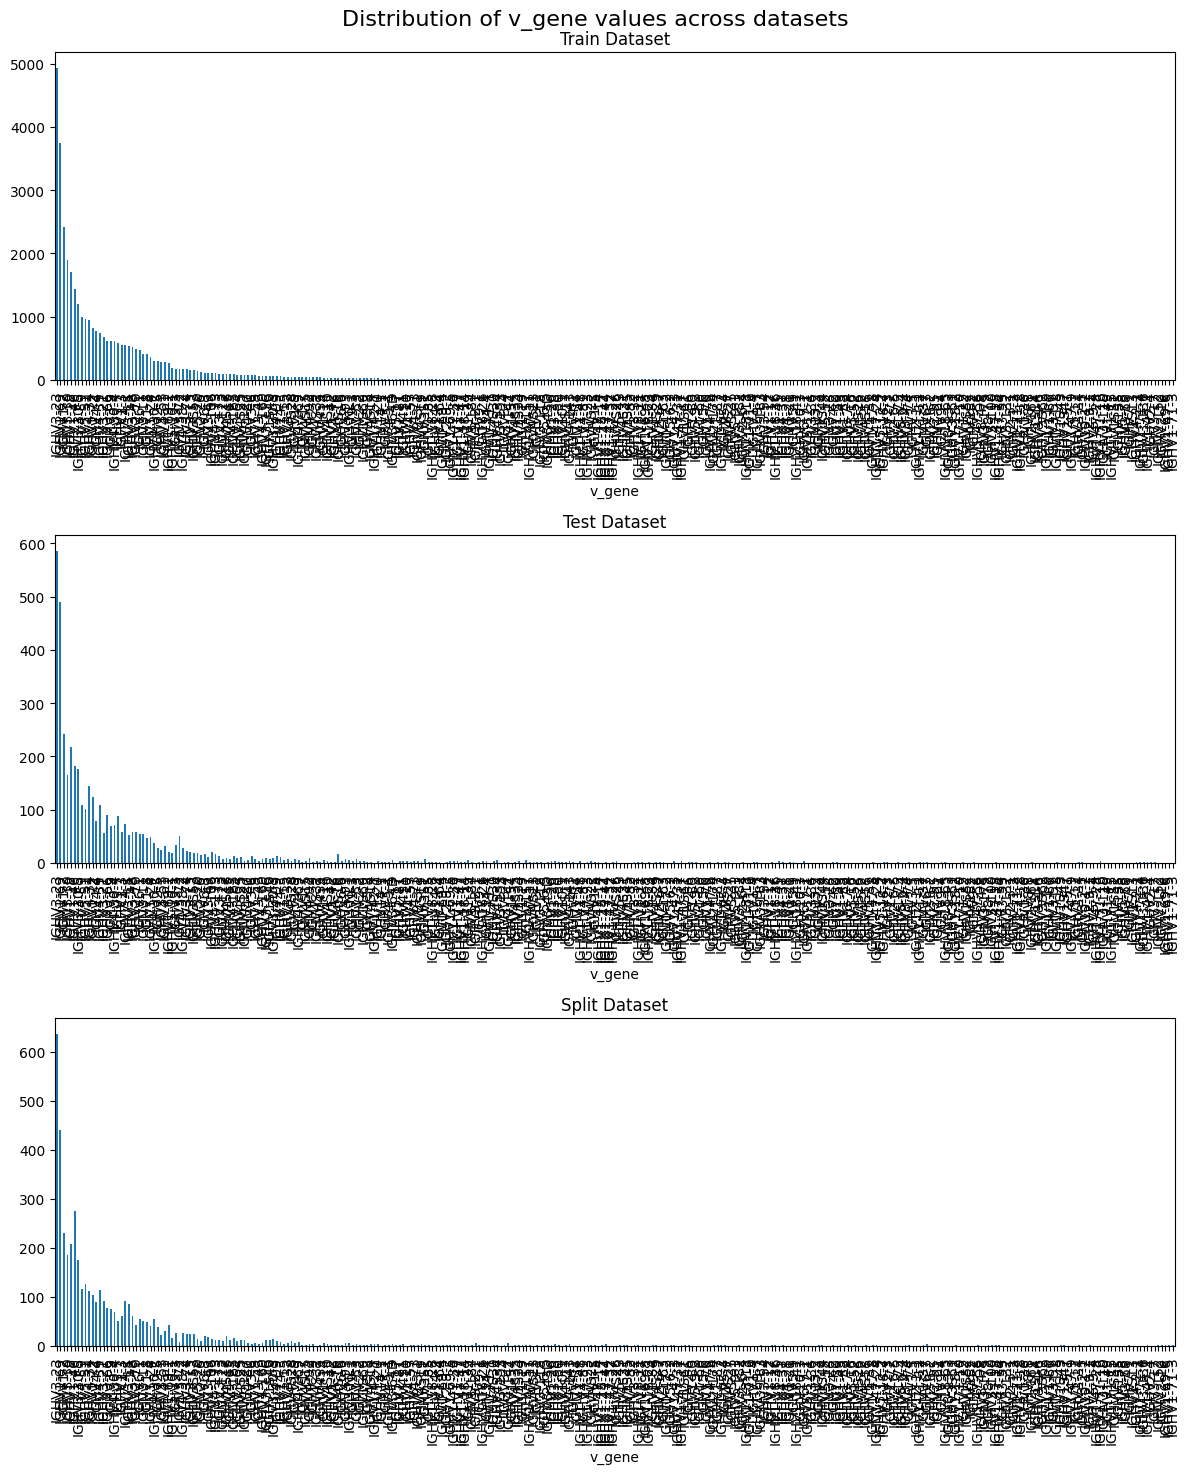

In [22]:
# an optional step to check that v gene distributions are roughly the same across the 3 datasets
plot_v_gene_distributions(df_train, df_val, df_test)

In [9]:
# train the model

def train_fabcon(
    ds: str = typer.Option(..., help="HF dataset with train, eval, and test splits"),
    pretrained_model_path: str = typer.Option(..., help = "Path to pretrained model"),
    tokenizer_path: str = typer.Option(..., help="Path to the tokenizer"),
    freeze_encoder: bool = typer.Option(True, help = "Specify whether or not to freeze the en(de)coder"),
    checkpoint_path: str = typer.Option("classifier-checkpoints/", help="Path to save checkpoints"),
    model_save_path: str = typer.Option("classifier-model/", help="Path to save the final model"),
    logging_path: str = typer.Option("tensorboard/", help="Path to save Tensorboard logging"),
    metrics_path: str = typer.Option(".", help="Specify a folder path to write test metrics and logs"),
    seed: int = typer.Option(42, help = "Set random seed."),
    task_name: str = typer.Option("0", help = 'Task Name'),
    use_fp16: bool = typer.Option(False, help = 'Specify to use 16-bit precision instead of 32-bit precision'),
    batch_size: int = typer.Option(64, help = 'Specify batch size'),
    grad_acc: int = typer.Option(1, help = 'Specify number of gradient accumulation steps'),
    epochs: int = typer.Option(3, help = 'Specify number of epochs'),
    warmup_ratio: float = typer.Option(0.05, help = 'Specify warmup ratio'),
    learning_rate: float = typer.Option(0.0001, help = 'Specify learning rate'),
    no_cuda: bool = typer.Option(False, help = 'Specify True to NOT use CUDA'),
    deepspeed: str = typer.Option(None, help="Specify deepspeed config path")
    ):
    """
    Train a sequence classifier from RoFormer models.
    """


    set_seed(seed)

    model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_path, 
                                                               num_labels=2, 
                                                               trust_remote_code=True)
#     print(model.config)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path,
                                              max_len=model.config.max_position_embeddings)

  # Freeze all layers except the classifier layer
    if freeze_encoder:
        for name, param in model.named_parameters():
            if 'classifier' not in name:
                param.requires_grad = False
        # 
        # if 'Falcon' in model.config.architectures[0]:
        #     for name, param in model.named_parameters():
        #         if 'score' in name:
        #             param.requires_grad = True
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

    tokenized_dataset = load_from_disk(ds)

    
    print("----------------------------------------------")
    print(f"Train length: {tokenized_dataset['train'].num_rows}")
    print(f"Eval length: {tokenized_dataset['eval'].num_rows}")
    print(f"Test length: {tokenized_dataset['test'].num_rows}")

    training_args = TrainingArguments(
    output_dir=checkpoint_path,
    overwrite_output_dir=True,
    logging_dir=logging_path,
    report_to='all',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=grad_acc,
    num_train_epochs=epochs,
    warmup_ratio=warmup_ratio,
    learning_rate=learning_rate,
    lr_scheduler_type='cosine',
    seed=seed,
    weight_decay=0.05,
    eval_steps=500,
    evaluation_strategy='steps',
    # evaluation_strategy='epoch',  # evaluate every epoch
    # save_strategy='epoch',  # save model every epoch
    save_strategy='steps',  
    metric_for_best_model='auc',  # monitor the AUC metric
    load_best_model_at_end=True,  # load the best model after training
    fp16=use_fp16,
    no_cuda=no_cuda,
    deepspeed=deepspeed
)
    early_stopping = EarlyStoppingCallback(
    early_stopping_patience=10,  # number of evaluations to wait before stopping
    early_stopping_threshold=0.01  # minimum change to qualify as improvement
    )

    mc = MetricCallback(label_names=['negative', 'positive'])

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset['train'],
        eval_dataset=tokenized_dataset['eval'],
        data_collator=data_collator,
        compute_metrics=mc.compute_metrics,
        callbacks=[early_stopping]  
    )

    trainer.train()
    trainer.save_model(model_save_path)

    test_metrics = trainer.predict(tokenized_dataset['test'])
    outpath = Path(f"{metrics_path}",
                f"{task_name}-metrics",
                f"{task_name}.{seed}.test_metrics.json")

    outpath_pred = Path(f"{metrics_path}",
                f"{task_name}-metrics",
                f"{task_name}.{seed}.test_predictions.csv")

    outpath.parent.mkdir(parents=True, exist_ok=True)

    with outpath.open('w') as jason:
        json.dump(test_metrics.metrics, jason)

    test_logits = torch.Tensor(test_metrics.predictions).softmax(dim=1).numpy()
    test_labels = test_metrics.label_ids

    dat = pd.DataFrame(test_logits, columns = ['neg','pos'])
    dat['label'] = test_labels
    dat.to_csv(outpath_pred, index=False)

train_fabcon(ds="/home/ubuntu/data/FinalYearProject/machine_learning/data_preparation/datasetdict_tokenized_labelled.set", 
     pretrained_model_path="/home/ubuntu/data/models", 
     tokenizer_path=tokenizer_path,
     freeze_encoder=False,
     checkpoint_path="/home/ubuntu/data/FinalYearProject/machine_learning/autoantibody_model/trained_model/classifier-checkpoints",
     model_save_path="/home/ubuntu/data/FinalYearProject/machine_learning/autoantibody_model/trained_model/classifier-model",
     logging_path="/home/ubuntu/data/FinalYearProject/machine_learning/autoantibody_model/trained_model/tensorboard",
     metrics_path="/home/ubuntu/data/FinalYearProject/machine_learning/autoantibody_model/trained_model",
     seed=30,
     warmup_ratio=0.05,
     learning_rate=0.00001,
     task_name="0",
     use_fp16=False,
     batch_size=16,
     grad_acc=1,
     epochs=10,
     no_cuda=False,
     deepspeed=None
     )


Some weights of FalconForSequenceClassification were not initialized from the model checkpoint at /home/ubuntu/data/models and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ubuntu/miniconda3/envs/ml/lib/python3.10/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


----------------------------------------------
Train length: 37179
Eval length: 4529
Test length: 4630
[2024-11-07 10:15:12,045] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/ubuntu/miniconda3/envs/ml/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/ubuntu/miniconda3/envs/ml/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `dlopen'
/home/ubuntu/miniconda3/envs/ml/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `dlclose'
/home/ubuntu/miniconda3/envs/ml/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `dlerror'
/home/ubuntu/miniconda3/envs/ml/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `dlsym'
collect2: error: ld returned 1 exit status


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [12]:
# combine the two independent datasets
import numpy as np

# Read the files
csv_df = pd.read_csv(independent_dataset_1, usecols=['vh_full', 'label', 'v_call'])

tsv_df = pd.read_csv(independent_dataset_2, sep='\t', usecols=['Heavy Sequence', 'Label', 'v_gene_heavy', 'junction_aa_heavy'])


tsv_df['Heavy Sequence']
csv_df['vh_full']
csv_df['junction_aa_heavy'] = ""
# # Rename columns for consistency
csv_df = csv_df.rename(columns={'vh_full': 'sequence_vh', 'label': 'label', 'v_call': 'v_gene'})
tsv_df = tsv_df.rename(columns={'Heavy Sequence': 'sequence_vh', 'Label': 'label', 'v_gene_heavy': 'v_gene'})

# # Concatenate dataframes
independent_df = pd.concat([csv_df, tsv_df], ignore_index=True)
independent_df = independent_df[~independent_df['sequence_vh'].isin(df['sequence_aa'])]
print(independent_df)

# independent_df = independent_df.dropna()

independent_df['label'] = independent_df['label'].astype(str).str.lower().apply(
    lambda x: int(1) if 'human' in x else (int(0) if 'viral' in x else np.nan)
)

independent_df = independent_df.drop_duplicates(keep='first')
independent_df = independent_df[independent_df['label'].isin([0, 1])]

independent_df.to_csv('./independent_dataset.csv', index=False)


# First, get the counts of each label
label_counts = independent_df['label'].value_counts()

# Get the minimum count between the two labels
min_count = min(label_counts[0], label_counts[1])

balanced_independent_df = (
    independent_df
    .groupby('label')
    .apply(lambda x: x.sample(min_count, random_state=42))
    .reset_index(drop=True)
)

balanced_independent_df.to_csv('./balanced_independent_dataset.csv', index=False)


                                             sequence_vh       v_gene  label  \
0      QVQLLESGGGVVQPGRSLRLSCAASGFTFSNYGMHWVRQAPGKGLE...  IGHV3-30*18  viral   
1      QVQLLESGGGVVQPGRSLRLSCAASGFTFSNYGMHWVRQAPGKGLE...  IGHV3-30*18  viral   
2      VQLVQSGAEVKKPGASVKVSCKASGYPFTSYGISWVRQAPGQGLEW...  IGHV1-18*01  viral   
3      VQLVQSGAEVKKPGASVKVSCKASGYPFTSYGISWVRQAPGQGLEW...  IGHV1-18*01  viral   
4      QVQLVQSGAEVKKPGASVKVSCKVSGYTLTELPVHWVRQAPGKGLE...  IGHV1-24*01  human   
...                                                  ...          ...    ...   
12909  QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYVMHWVRQAPGQGLE...      IGHV1-3  Human   
12911  QVQLQESGPGLVKPSQTLSLTCTVSGYAFTAYNIHWVRQAPGQGLE...     IGHV2-70  Human   
12913  QVQLQESGPGLVKPSETLSVTCSVSGDSMNNYYWTWIRQSPGKGLE...      IGHV4-4  Viral   
12914  QVQLQQPGAELVRPGASVKLSCKASGYTFTSYWINWVKQRPGQGLE...     IGHV1-46  Human   
12916  EVQLQQSGAELVRPGASVKMSCKASGYTFTSYNMHWVKQTPRQGLE...      IGHV1-3  Human   

                  junction_aa_heavy  
0

In [20]:
import pandas as pd
import numpy as np
import argparse
import torch
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
import os 
from datasets import (
    load_from_disk,
    DatasetDict, 
    Dataset
)
from transformers import (
    PreTrainedTokenizerFast,
    FalconForSequenceClassification,
    Trainer,
)
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, DistributedSampler

from sklearn.metrics import (
    roc_auc_score, 
    recall_score, 
    precision_score, 
    f1_score,
    matthews_corrcoef,
    average_precision_score
)

from utils import get_full_aa_sub

class AntibodyRepertoireDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self,index):
        return self.sequences[index]


def setup(rank, world_size):
    # initialize the process group
    dist.init_process_group("nccl", rank=rank, world_size=world_size)
    print('RANK',rank)
    torch.cuda.set_device(rank)

def get_eos_embedding(logits, input_ids, pad_token_id, rank):
    """
    :return:
    """
    sequence_lengths = torch.eq(input_ids, pad_token_id).int().argmax(-1) - 1
    sequence_lengths = sequence_lengths % input_ids.shape[-1]
    sequence_lengths = sequence_lengths.to(rank)
    pooled_logits = logits[torch.arange(input_ids.shape[0], device=rank), sequence_lengths]
    return pooled_logits
# def get_eos_embedding(hidden_states, input_ids, pad_token_id, rank):
#     # Get attention mask based on pad token
#     attention_mask = (input_ids != pad_token_id).long()
    
#     # Find the last non-padded position for each sequence
#     last_positions = attention_mask.sum(dim=1) - 1  # subtract 1 to get 0-based index
    
#     # Ensure indices are valid
#     batch_size, seq_length = input_ids.size()
#     last_positions = torch.clamp(last_positions, 0, seq_length - 1)
    
#     # Get batch indices
#     batch_indices = torch.arange(batch_size, device=rank)
    
#     # Extract the embeddings for the last token of each sequence
#     last_token_embeddings = hidden_states[batch_indices, last_positions]
    
#     return last_token_embeddings
    
def cleanup():
    dist.destroy_process_group()

def predict_old(
    input_path: str,
    output_path: str,
    tokenizer_path: str,
    model_path: str,
    local_rank: int = 0,
    world_size: int = 1
    # vh_column: str = typer.Option("sequence_vh", help ="Column in input file which contains the heavy chain sequence")
):
    setup(local_rank,
          world_size)
    # dist.init_process_group(backend='nccl')
    # torch.cuda.set_device(local_rank)
    if input_path.endswith('.csv'):
        #LOAD DATASET
        dataset_to_predict=pd.read_csv(input_path)
        original_columns = dataset_to_predict.copy()
        available_columns=dataset_to_predict.columns
        
        if 'label' in available_columns:
            dataset_to_predict=dataset_to_predict[['sequence_vh','label']].copy()
            dataset_to_predict['label'] = dataset_to_predict['label'].astype(int)

        else:
            dataset_to_predict=dataset_to_predict[['sequence_vh']].copy()
    
    # output from pipeline is tsv files
    elif input_path.endswith('.tsv'):
        dataset_to_predict=pd.read_csv(input_path, sep='\t')  
        available_columns=dataset_to_predict.columns
        if 'sequence_vh' in available_columns:
            raise NameError('tsv file already has sequence_vh column. Please remove it to continue')
        elif 'sequence_alignment' not in available_columns and 'germline_alignment_d_mask' not in available_columns:
            raise NameError('tsv file must have sequence_alignment and germline_alignment_d_mask columns') 
        else: 
            dataset_to_predict['sequence_vh'] = dataset_to_predict.apply(
            lambda row: get_full_aa_sub(str(row['sequence_alignment']), str(row['germline_alignment_d_mask'])), 
            axis=1
            )
            original_columns = dataset_to_predict.copy()


    #PREPARE DATASET INTO HF FORMAT
    dataset_to_predict['sequence']='Ḣ'+dataset_to_predict['sequence_vh']

    # Dataset is a HuggingFace dataset object that can be converted from Pandas.
    # dd = DatasetDict({
    #     "test": Dataset.from_pandas(dataset_to_predict)
    # })
    
    tokenizer = PreTrainedTokenizerFast.from_pretrained(tokenizer_path)
    def collate_fn(text, tokenizer=tokenizer):
        # pads to max length in batch
        tokenized_input = tokenizer(
            text,
            return_tensors='pt',
            padding=True,
            max_length=256
        )
        tokenized_input['text'] = text
        return tokenized_input
    model = FalconForSequenceClassification.from_pretrained(model_path).to(local_rank)
    # model = FalconForSequenceClassification.from_pretrained(model_path).eval()
    # model = model.eval()
    model = DDP(model, device_ids=[local_rank])
    sequences = dataset_to_predict['sequence'].unique().tolist()
    dataset = AntibodyRepertoireDataset(sequences)
    sampler = DistributedSampler(dataset, num_replicas=world_size, rank=local_rank)
    dataloader = DataLoader(dataset, batch_size=16, sampler=sampler,
                            collate_fn=collate_fn)
    pad_token_id = 2
    sequences = []
    human_probabilities = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            inputs = {
                'input_ids': batch['input_ids'].to(local_rank),
                'attention_mask': batch['attention_mask'].to(local_rank)
            }

            o = model(**inputs).logits
            probs = torch.softmax(o.cpu(), dim=1).detach().numpy()  
            
            probs = probs[:, -1] 
            # print(probs)
            # print(batch['text'])
            # sequences are stored in batch['text']
            # probabilities are stored in probs
            # I want to connect 1 sequence to 1 probability
            # print(tuple(zip(batch['text'], probs)))
            # outputs.append(o.cpu())
            human_probabilities.extend(probs)
            sequences.extend(batch['text'])
    output_df = pd.DataFrame({
        'sequence_vh': sequences,
        'human_prob': human_probabilities
    })

    merged_df = dataset_to_predict.merge(
    output_df,
    left_on='sequence',
    right_on='sequence_vh',
    how='left'
)

    # Define conditions
    conditions = [
        merged_df['human_prob'] > 0.99,
    ]

    # Define choices for each condition
    choices = ['human']

    # Apply conditions to create 'human_viral_prediction' column
    merged_df['prediction'] = np.select(
        conditions, choices, default=""
    )
    print(merged_df)

    if ".csv" in output_path:
        # final_output = pd.merge(
        #     original_columns,
        #     dataset_to_predict[['sequence_vh', 'viral_prob', 'human_prob', 'human_viral_prediction']],
        #     on='sequence_vh',
        #     how='left'
        # )
        merged_df.to_csv(output_path,index=None)
    elif ".tsv" in output_path:
        # original_columns['sequence_vh'] = original_columns.apply(
        #     lambda row: get_full_aa_sub(str(row['sequence_alignment']), str(row['germline_alignment_d_mask'])), 
        #     axis=1
        # )
        # final_output = pd.merge(
        #     original_columns,
        #     dataset_to_predict[['sequence_vh', 'viral_prob', 'human_prob', 'human_viral_prediction']],
        #     on='sequence_vh',
        #     how='left'
        # )
        merged_df.to_csv(output_path,index=None,sep="\t")

    # viral_probabilities = merged_df['viral_probs'].values
    if 'label' in available_columns:
        labels=merged_df['label'].values
        probs=merged_df['human_prob'].values
        probs_binary=[1 if x>0.5 else 0 for x in probs]
        # print(labels)
        # print(probs)
        auc=roc_auc_score(labels, probs)
        aupr=average_precision_score(labels, probs)
        f1=f1_score(labels,probs_binary)
        precision=precision_score(labels,probs_binary)
        recall=recall_score(labels,probs_binary)
        mcc = matthews_corrcoef(labels, probs_binary)
        
        print('roc_auc:',auc,'average_precision_score',aupr,'f1:',f1,'precision:',precision,'recall:',recall,'mcc',mcc)

    cleanup()



In [11]:
cleanup()

In [21]:
# These two environment variables are necessary to get the GPU-ified version working
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '12355'



predict_old('./balanced_independent_dataset.csv', 
        './balanced_independent_dataset_post_test.csv', 
        tokenizer_path, 
        '/home/ubuntu/data/FinalYearProject/machine_learning/human_viral_model/trained_model/classifier-model',
        0,
        1)

RANK 0


  0%|          | 0/89 [00:00<?, ?it/s]

/home/ubuntu/miniconda3/envs/ml/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2849: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 89/89 [00:05<00:00, 16.03it/s]


                                          sequence_vh_x  label  \
0     EVQLVQSGGGVVQPGGSLRLSCAASGFTFSSYSVHWVRQAPGKGLE...      0   
1     QVQLVQSGSELKKPGASVKLSCKASGFTFSDYAMIWVRQAPGQGLE...      0   
2     QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYGISWVRQAPGQGLE...      0   
3     QVQLVESGGGVVQPGRSLRLSCAASGFTFSSYGMHWVRQAPGKGLE...      0   
4     QVQLVESGGGVAQPGGSLRLSCAASGFSFSTFAMHWVRQAPGTGLE...      0   
...                                                 ...    ...   
1615  QVQLVQSGAEVKKPGSSVKVSCKASGYTFTSYHIHWVRQAPGQGLE...      1   
1616  EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...      1   
1617  EVQLVESGGGLVQPGGSLRLSCAASGFSLSNYNMGWVRQAPGKGLE...      1   
1618  QVQLQESGPGLVKPSQTLSLTCTVSGGSISSGYYWSWIRQHPGKGL...      1   
1619  QVQLQQSGPGLVKPSQTLSLTCAISGDSVSSNSAAWGWIRQSPGRG...      1   

                                               sequence  \
0     ḢEVQLVQSGGGVVQPGGSLRLSCAASGFTFSSYSVHWVRQAPGKGL...   
1     ḢQVQLVQSGSELKKPGASVKLSCKASGFTFSDYAMIWVRQAPGQGL...   
2     ḢQVQLVQSGAEVKKPGASVKVSCK

In [22]:
import pandas as pd
# Calculate the number of matches between 'classification' and 'predicted_class'
a = pd.read_csv('./balanced_independent_dataset_post_test.csv')
condition_1 = ((a['label'] == 1) & (a['human_prob'] > 0.99))
condition_2 = ((a['human_prob'] > 0.99))
print('confident and correct:', condition_1.sum())
print('confident:', condition_2.sum())


# condition_3 = ((a['label'] == 1) & (a['viral_prob'] > 0.95))
# condition_4 = (a['label'] == 0) & (a['viral_prob'] < 0.05)

# condition_5 = (a['label'] == 1)
condition_6 = (a['label'] == 1)
# print('confident, viral and correct', condition_3.sum())
# print('confident, human and correct', condition_4.sum())
# print('total viral', condition_5.sum())
print('total human',condition_6.sum())

# condition_7 =  (a['viral_prob'] > 0.95)
# condition_8 = (a['viral_prob'] < 0.05)
# print('confident, viral', condition_7.sum())
# print('confident, human', condition_8.sum())

# condition_9 = ((a['label'] == 1) & (a['viral_prob'] < 0.95))
# condition_10 = ((a['label'] == 0) & (a['viral_prob'] > 0.05))

# print('not confident, viral', condition_9.sum())
# print('not confident, human', condition_10.sum())
# matching_rows_count = condition_1.sum()
# confident_but_incorrect = condition_2.sum()
total_rows_count = len(a)
print('total rows:', total_rows_count)
# percentage = (matching_rows_count / confident_but_incorrect) * 100 if confident_but_incorrect > 0 else 0
# print(f"Percentage of confident calls which were correct: {percentage:.2f}%")


confident and correct: 502
confident: 546
total human 810
total rows: 1620


In [1]:
from utils import get_full_aa_sub

seq = ".....................................................................GCAGCCTCTGGATTCACCTTC............GCTAGTTATGAAATGAACTGGGTCCGCCAGGCTCCTGGGAAGGGGCTGGAGTGGATTTCATACATTAGTAGTCGT......GGTAGTACCACATACTACGCAGACTCTGTGAAG...GGCCGATTCACCATCTCCAGAGACAACGCCAAGAACTCACTGTATCTGCAAGTGAACAGCCTGAGAGCCGAGGACACGGCTGTTTATTACTGCGCGAGAGATAGCCCTTCCTCGCGGGGGAGCCCCAACCTGTACTACTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCA"
gadm = "GAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCTTGGTACAGCCTGGAGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTC............AGTAGTTATGAAATGAACTGGGTCCGCCAGGCTCCAGGGAAGGGGCTGGAGTGGGTTTCATACATTAGTAGTAGT......GGTAGTACCATATACTACGCAGACTCTGTGAAG...GGCCGATTCACCATCTCCAGAGACAACGCCAAGAACTCACTGTATCTGCAAATGAACAGCCTGAGAGCCGAGGACACGGCTGTTTATTACTGTGCGAGAGANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNACTACTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCA"
print(get_full_aa_sub(seq, gadm))

/home/ubuntu/miniconda3/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


EVQLVESGGGLVQPGGSLRLSCAASGFTFASYEMNWVRQAPGKGLEWISYISSRGSTTYYADSVKGRFTISRDNAKNSLYLQVNSLRAEDTAVYYCARDSPSSRGSPNLYYFDYWGQGTLVTVSS


In [11]:
import numpy as np
import pandas as pd
prepared_data = pd.read_csv('/home/ubuntu/data/FinalYearProject/machine_learning/predict/SE_222_classified.tsv', sep='\t')

human_rows = prepared_data[prepared_data['prediction'] == 'human'].shape[0]

total_rows = prepared_data.shape[0]
print(total_rows)
print(human_rows)
print((human_rows)/total_rows)


120800
7891
0.06532284768211921


In [1]:
import pandas as pd

df = pd.read_parquet("/Users/jess/Downloads/clonotype_results_ftd_0.1_complete_olgafied.parquet")

rows, columns = df.shape
print(f"Rows: {rows}, Columns: {columns}")


Rows: 13499425, Columns: 27
